In [1]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import time
import json
import re

In [2]:
current_folder = Path.cwd()
tesi_folder = Path('~/Scuola/now/thesis').expanduser()

In [3]:
def plot_metric(axis, metrics, label, xrange=None, ylim=[0, 200], color='black', legend_loc=None):
    if xrange is None:
        done = len(metrics)
        xrange = list(range(1, done + 1))
        
    axis.plot(
        xrange, metrics, label=label, color=color
    )

    if ylim:
        axis.set_ylim(ylim)
    
    if legend_loc:
        axis.legend(loc=legend_loc)


def plot_metrics(axis, train_metrics, eval_metrics, xrange=None, train_ylim=[0, 30], eval_ylim=[0, 100]):
    plot_metric(
        axis,
        train_metrics,
        'on TRAIN set (S1, S6, S7, S8)',
        xrange=xrange,
        ylim=train_ylim,
        color='red',
        legend_loc='upper left'
    )
    
    axis = axis.twinx()
        
    plot_metric(
        axis,
        eval_metrics,
        'on EVAL set (S9, S11)',
        xrange=xrange,
        ylim=eval_ylim,
        color='green',
        legend_loc='upper right'
    )
    

def make_axis_great_again(ax, xlim, ylim, title):
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.grid(True)
    ax.set_title(title)
    
    ax.set_ylabel('average MPJPE relative to pelvis (mm)')
    ax.set_xlabel('epoch')

In [4]:
def get_figsize(n_rows, n_cols, row_size=8, column_size=24):
    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols, heigth=8, width=24):
    fig_size = get_figsize(n_rows, n_cols, row_size=heigth, column_size=width)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=fig_size)
    return fig, ax

In [5]:
def get_lines(f_path):
    lines = []

    with open(f_path, 'r') as reader:
        lines = reader.readlines()
        lines = [
            line.strip()
            for line in lines
        ]
        
    return lines


def parse_metrics_log(f_path, verbose=True):
    lines = get_lines(f_path)
    split_index = lines.index('... on EVALuation set')
    training_stop_index = split_index - 1
    eval_start_index = split_index + 1
    
    is_fp_number = lambda x: not (re.match('\d.', x) is None)
    parse_fp_number = lambda x: float(x)
    
    train_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[:training_stop_index])
    )
    
    eval_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[eval_start_index:])
    )
    
    train_metrics, eval_metrics = list(train_metrics), list(eval_metrics)
    
    if verbose:
        print('found {:d} / {:d} training / validation epochs'.format(
            len(train_metrics), len(eval_metrics)
        ))
        
    return train_metrics, eval_metrics


def parse_job_log(f_path):
    lines = get_lines(f_path)
    pass  # todo

found 238 / 238 training / validation epochs
found 29 / 29 training / validation epochs


Text(0.5, 0.98, 'Algebraic, lr=1e-5, pretraining JUST backbone, shuffling (train AND eval sets), images ~ 384 x 384 pixels')

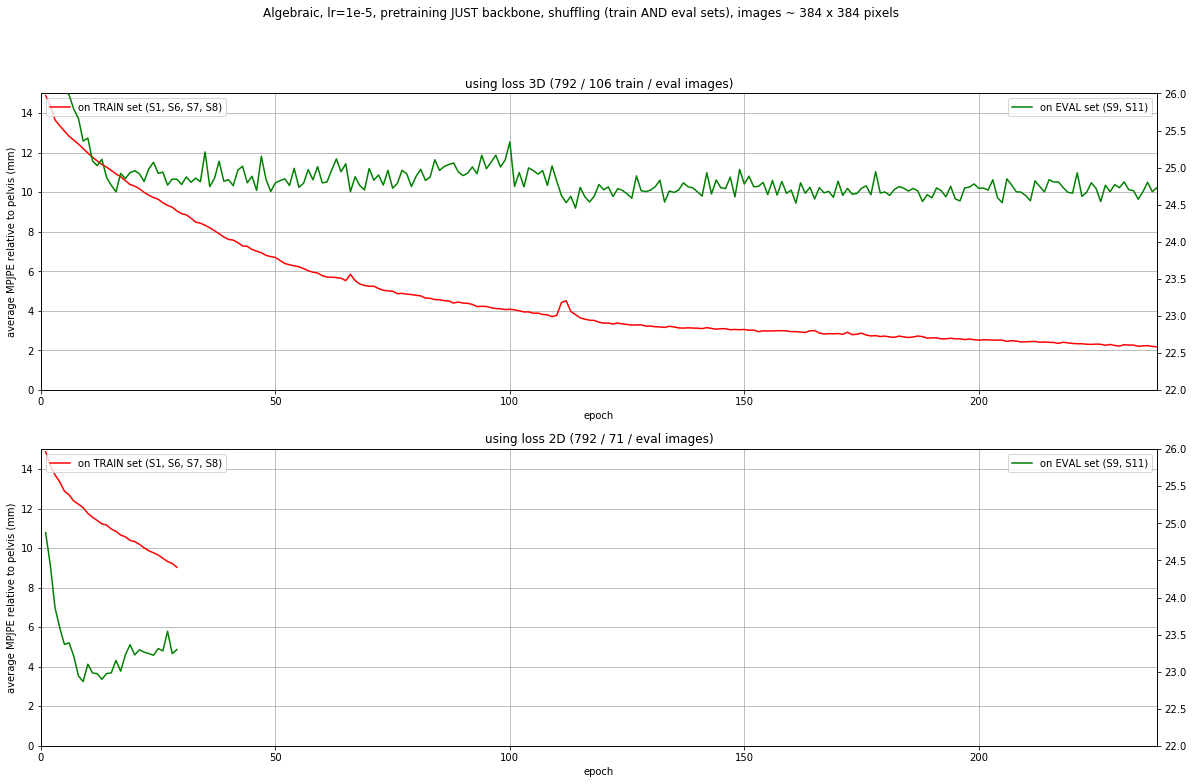

In [11]:
fig, axis = get_figa(2, 1, heigth=6, width=20)

train_ylim = [0, 15]
eval_ylim = [22, 26]

train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / '792.txt')
ax = axis.ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(ax, [0, 238], train_ylim, 'using loss 3D (792 / 106 train / eval images)')


train_metrics, eval_metrics = parse_metrics_log(tesi_folder / 'metrics_logs' / '9_23.txt')
ax = axis.ravel()[1]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(ax, [0, 238], train_ylim, 'using loss 2D (792 / 71 / eval images)')

fig.suptitle('Algebraic, lr=1e-5, pretraining JUST backbone, shuffling (train AND eval sets), images ~ 384 x 384 pixels')